In [43]:
import matplotlib.pyplot as plt
import ntpath
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import os
import cv2
import numpy as np
import pandas as pd
import random
import re
from sklearn.model_selection import train_test_split
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
def extract_number_from_filename(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

def load_and_display_images(folder_path):
    images = []
    image_names = []

    images_in = os.listdir(folder_path)
    images_in = sorted(images_in, key=extract_number_from_filename)

    for file_name in images_in:
        file_path = os.path.join(folder_path, file_name)
        img = cv2.imread(file_path)

        # Crop the image to the region of interest
        x, y, w, h = 96, 400, 384, 80
        cropped_img = img[y:y+h, x:x+w]
        
        # keep this as an option, maybe not needed though...
        #cropped_img = cv2.GaussianBlur(cropped_img, (3,3), 0)
        cropped_img = cropped_img/255

        images.append(cropped_img)
        image_names.append(file_name)

    return images, image_names

folder_path = "C:\\Users\\nfeda\\yr4\\Collab\\Processed_data_cnn\\good_data"
captured_images = []
image_names = []
loaded_images = []
unloaded_images = []

files = os.listdir(folder_path)

for file_name in files:
    print(file_name)
    file_path = os.path.join(folder_path, file_name)
    temp_images, temp_image_names = load_and_display_images(file_path)
    print(len(temp_images))
    captured_images.append(temp_images)
    image_names.append(temp_image_names)

# Extract images from the first set (HRNL folder)
hrnl_images = captured_images[0]
hrnlbend_images = captured_images[1]
rlbend_images = captured_images[2]
rnlbend_images = captured_images[3]
wbrl_images = captured_images[4]
wbrnl_images = captured_images[5]


# remove some frames from the beginning to balance
hrnlbend_images = hrnlbend_images[79:]
rlbend_images = rlbend_images[12:]
wbrnl_images = wbrnl_images[3:]

# Remove excess frames from the end
del hrnl_images[:26]
del rnlbend_images[:140]
del wbrl_images[:156]

print("hrnlbend_images: ", len(hrnlbend_images))
print("rlbend_images: ", len(rlbend_images))
print("wbrnl_images: ", len(wbrnl_images))
print("hrnl_images: ", len(hrnl_images))
print("rnlbend_images: ", len(rnlbend_images))
print("wbrl_images: ", len(wbrl_images))



HRNL
818
HRNLBend
867
RLBend
976
RNLBend
736
WBRL
836
WBRNL
949
hrnlbend_images:  788
rlbend_images:  964
wbrnl_images:  946
hrnl_images:  792
rnlbend_images:  596
wbrl_images:  680


In [46]:
# Categorize half of the remaining images as loaded and half as unloaded

mixed_data = []

unloaded_images.extend(hrnlbend_images[:len(hrnlbend_images)//2]) # 473 without deletions
loaded_images.extend(hrnlbend_images[len(hrnlbend_images)//2:])
mixed_data.extend(hrnlbend_images[:len(hrnlbend_images)//2])
mixed_data.extend(hrnlbend_images[len(hrnlbend_images)//2:])


unloaded_images.extend(rlbend_images[:len(rlbend_images)//2]) # 494 without deletions
loaded_images.extend(rlbend_images[len(rlbend_images)//2:])
mixed_data.extend(rlbend_images[:len(rlbend_images)//2])
mixed_data.extend(rlbend_images[len(rlbend_images)//2:])

unloaded_images.extend(wbrnl_images[:len(wbrnl_images)//2]) # 476
loaded_images.extend(wbrnl_images[len(wbrnl_images)//2:])
mixed_data.extend(wbrnl_images[:len(wbrnl_images)//2])
mixed_data.extend(wbrnl_images[len(wbrnl_images)//2:])

unloaded_images.extend(hrnl_images[:len(hrnl_images)//2]) # 396 ish without deletions
loaded_images.extend(hrnl_images[len(hrnl_images)//2:]) 
mixed_data.extend(hrnl_images[:len(hrnl_images)//2])
mixed_data.extend(hrnl_images[len(hrnl_images)//2:])

unloaded_images.extend(rnlbend_images[:len(rnlbend_images)//2]) # 298
loaded_images.extend(rnlbend_images[len(rnlbend_images)//2:])
mixed_data.extend(rnlbend_images[:len(rnlbend_images)//2])
mixed_data.extend(rnlbend_images[len(rnlbend_images)//2:])

unloaded_images.extend(wbrl_images[:len(wbrl_images)//2]) # 340
loaded_images.extend(wbrl_images[len(wbrl_images)//2:])
mixed_data.extend(wbrl_images[:len(wbrl_images)//2])
mixed_data.extend(wbrl_images[len(wbrl_images)//2:])


classifications = [0] * (len(hrnlbend_images)//2) + [1] * (len(hrnlbend_images)//2)  + [0] * (len(rlbend_images)//2) + [1] * (len(rlbend_images)//2) + [0] * (len(wbrnl_images)//2) + [1] * (len(wbrnl_images)//2) + [0] * (len(hrnl_images)//2) + [1] * (len(hrnl_images)//2) + [0] * (len(rnlbend_images)//2) + [1] * (len(rnlbend_images)//2) + [0] * (len(wbrl_images)//2) + [1] * (len(wbrl_images)//2)

print("Number of Unloaded Images:", len(unloaded_images))
print("Number of Loaded Images:", len(loaded_images))
print("Overall images:", len(mixed_data))
print("Overall Classifications:", len(classifications))

Number of Unloaded Images: 4766
Number of Loaded Images: 4766
Overall images: 4766
Overall Classifications: 4766


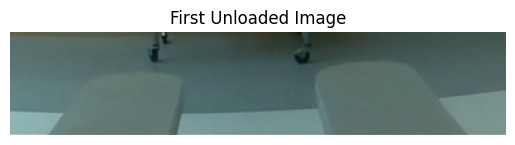

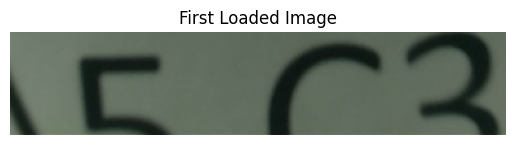

In [31]:
plt.imshow(cv2.cvtColor(unloaded_images[0], cv2.COLOR_BGR2RGB))
plt.title("First Unloaded Image")
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(loaded_images[0], cv2.COLOR_BGR2RGB))
plt.title("First Loaded Image")
plt.axis('off')
plt.show()

In [47]:
def zoom(image_to_zoom):
  zoom_func = iaa.Affine(scale=(1,1.3))
  z_image = zoom_func.augment_image(image_to_zoom)
  return z_image

def pan(image_to_pan):
  pan_func = iaa.Affine(translate_percent={"x": (-0.1,0.1), "y": (-0.1,0.1)})
  pan_image = pan_func.augment_image(image_to_pan)
  return pan_image

def img_random_brightness(image_to_brighten):
  bright_func = iaa.Multiply((0.2,1.2))
  bright_image = bright_func.augment_image(image_to_brighten).astype("uint8")
  return bright_image

def img_random_flip(image_to_flip):
  flipped_image = cv2.flip(image_to_flip, 1)
  return flipped_image

def random_augment(image_to_augment, label):
  augment_image = image_to_augment
  if np.random.rand() < 0.5:
      augment_image = zoom(augment_image)
  if np.random.rand() < 0.5:
      augment_image = pan(augment_image)
  if np.random.rand() < 0.5:
      augment_image = img_random_brightness(augment_image)
  if np.random.rand() < 0.5:
      augment_image = img_random_flip(augment_image)
  return augment_image, label


In [57]:
def batch_generator(image_paths, classifications, batch_size, is_training):
    image_paths = np.asarray(image_paths, dtype=np.float32)
    while True:
        batch_img = []
        batch_classifications = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths)-1)
            if is_training:
                im, label = random_augment(image_paths[random_index], classifications[random_index])
            else:
                im = image_paths[random_index]
                label = classifications[random_index]
            batch_img.append(im)
            batch_classifications.append(label)
        yield np.asarray(batch_img), np.asarray(batch_classifications)



In [58]:
#height, width = mixed_data.shape[1], mixed_data.shape[2]
channels = 3  # Assuming grayscale, set to 3 for RGB images


# Step 4: Split Data
X_train, X_valid, y_train, y_valid = train_test_split(mixed_data, classifications, test_size=0.2, random_state=6)

# Step 5: Define Model
model = Sequential([
    Convolution2D(32, (3, 3), activation='relu', input_shape=(80, 384, channels)),
    MaxPooling2D((2, 2)),
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Step 6: Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Step 7: Train Model
history = model.fit(batch_generator(X_train, y_train, 200, 1), steps_per_epoch=100, epochs=10, validation_data = batch_generator(X_valid, y_valid, 200, 0), validation_steps=200, verbose=1, shuffle=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Epoch 1/10
 15/100 [===>..........................] - ETA: 8:20 - loss: 0.9262 - accuracy: 0.4963

KeyboardInterrupt: 